In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import gc
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from importlib import reload
import date
reload(date)
from date import *
import model
reload(model)
from model import *
from metric import get_weights, NWRMSLE_log

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = load_data_in_date_range('./data/train_processed.csv', '2017-04-04', '2017-08-15', 110000000)

Reading batch from position 110000000, batch size 10000000...
Filtering 10000000...
Filtered 8659998, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 120000000, batch size 10000000...
Filtering 5497041...
Filtered 5497041, mapping...
Mapped, reducing...
Batch done.
End of dataset is found.


In [3]:
print('Reading additional datasets')
items = pd.read_csv('./data/items_encoded.csv')
stores = pd.read_csv('./data/stores_encoded.csv')

Reading additional datasets


In [4]:
print('Converting data and joining additional data')
df = convert_unit_sales(df)
df = fill_empty_sales(df)
df, cols_categories = extend_dataset(df, items, stores)
del df['id']
del df['weight']
gc.collect()

Converting data and joining additional data


219

In [5]:
print('Adding lagged features')
df_prev = df[['item_nbr', 'store_nbr', 'date', 'unit_sales']]
df, cols_lagged = fill_lagged(df, df_prev, 12, 18, True)
del df_prev
gc.collect()
df.head()

Adding lagged features


/home/ubuntu/.local/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ubuntu/grocery/model.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_prev[colname] = df_prev['unit_sales']


Processing lagged 12...
Lagged 12 is done.
Processing lagged 13...
Lagged 13 is done.
Processing lagged 14...
Lagged 14 is done.
Processing lagged 15...
Lagged 15 is done.
Processing lagged 16...
Lagged 16 is done.
Processing lagged 17...
Lagged 17 is done.
Processing lagged 18...
Lagged 18 is done.


,date,store_nbr,item_nbr,unit_sales,onpromotion,weekday,weekend,salary,family,class,...,state,type,cluster,unit_sales(t-12),unit_sales(t-13),unit_sales(t-14),unit_sales(t-15),unit_sales(t-16),unit_sales(t-17),unit_sales(t-18)
0,1635,46,1695836,2.735787,False,5,True,False,30,2004,...,12,0,14,2.995732,3.288285,3.194839,2.603847,2.442347,3.597312,2.956699
1,1636,46,1695836,3.821825,False,6,True,False,30,2004,...,12,0,14,2.545531,2.995732,3.288285,3.194839,2.603847,2.442347,3.597312
2,1637,46,1695836,2.530094,False,0,False,False,30,2004,...,12,0,14,3.076736,2.545531,2.995732,3.288285,3.194839,2.603847,2.442347
3,1638,46,1695836,2.697052,False,1,False,False,30,2004,...,12,0,14,2.978395,3.076736,2.545531,2.995732,3.288285,3.194839,2.603847
4,1639,46,1695836,2.812786,True,2,False,False,30,2004,...,12,0,14,2.652361,2.978395,3.076736,2.545531,2.995732,3.288285,3.194839


In [6]:
cat_features = items_cols + stores_cols + ['store_nbr','item_nbr','onpromotion']
# combinations = list(itertools.combinations(cat_features, 1)) + \
# [['store_nbr','item_nbr'], ['store_nbr','item_nbr', 'onpromotion']]
combinations = [['onpromotion'], 
                ['item_nbr'],
                ['store_nbr'],
                ['store_nbr','item_nbr'], 
                ['store_nbr','item_nbr', 'onpromotion']]

print('Adding mean target encoding')
df, cols_mean = add_mean_encoding(df, combinations)
gc.collect()
!telegram-send "Lagged and mean extraction is ready, starting validation."
df.head()

Adding mean target encoding


,date,store_nbr,item_nbr,unit_sales,onpromotion,weekday,weekend,salary,family,class,...,unit_sales(t-14),unit_sales(t-15),unit_sales(t-16),unit_sales(t-17),unit_sales(t-18),mean_unit_sales_by_(onpromotion),mean_unit_sales_by_(item_nbr),mean_unit_sales_by_(store_nbr),mean_unit_sales_by_(store_nbr+item_nbr),mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)
0,1576,46,1695836,3.983762,True,2,False,False,30,2004,...,3.736180,2.562543,2.337137,4.329911,0.000000,1.969504,1.758596,1.352238,2.359225,3.759474
1,1577,46,1695836,2.771612,False,3,False,False,30,2004,...,2.519459,3.736180,2.562543,2.337137,4.329911,0.749576,1.758596,1.352238,2.359225,2.219200
2,1578,46,1695836,3.089621,False,4,False,False,30,2004,...,0.000000,2.519459,3.736180,2.562543,2.337137,0.749576,1.758596,1.352238,2.359225,2.219200
3,1579,46,1695836,3.789149,False,5,True,False,30,2004,...,0.000000,0.000000,2.519459,3.736180,2.562543,0.749576,1.758596,1.352238,2.359225,2.219200
4,1580,46,1695836,4.023117,False,6,True,True,30,2004,...,3.881564,0.000000,0.000000,2.519459,3.736180,0.749576,1.758596,1.352238,2.359225,2.219200


In [7]:
df['date'] = df['date'].astype('int16', copy=False)
df['store_nbr'] = df['store_nbr'].astype('int16', copy=False)
df['item_nbr'] = df['item_nbr'].astype('int32', copy=False)
df['weekday'] = df['weekday'].astype('int16', copy=False)
df['family'] = df['family'].astype('int16', copy=False)
df['class'] = df['class'].astype('int16', copy=False)
df['perishable'] = df['perishable'].astype('bool', copy=False)
df['city'] = df['city'].astype('int16', copy=False)
df['state'] = df['state'].astype('int16', copy=False)
df['type'] = df['type'].astype('int16', copy=False)
df['cluster'] = df['cluster'].astype('int16', copy=False)
gc.collect()

0

In [8]:
df = extract_by_date(df, '2017-05-16', '2017-08-15')
gc.collect()
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,weekday,weekend,salary,family,class,...,unit_sales(t-14),unit_sales(t-15),unit_sales(t-16),unit_sales(t-17),unit_sales(t-18),mean_unit_sales_by_(onpromotion),mean_unit_sales_by_(item_nbr),mean_unit_sales_by_(store_nbr),mean_unit_sales_by_(store_nbr+item_nbr),mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)
6,1596,46,1695836,3.227588,False,1,False,True,30,2004,...,3.660351,4.293878,4.023117,3.789149,3.089621,0.770096,2.755481,1.380306,3.639252,3.591883
7,1597,46,1695836,3.950643,True,2,False,False,30,2004,...,4.051241,3.660351,4.293878,4.023117,3.789149,1.963289,2.755481,1.380306,3.639252,3.939257
8,1598,46,1695836,3.029530,False,3,False,False,30,2004,...,3.208826,4.051241,3.660351,4.293878,4.023117,0.770096,2.755481,1.380306,3.639252,3.591883
9,1599,46,1695836,2.682198,False,4,False,False,30,2004,...,3.173486,3.208826,4.051241,3.660351,4.293878,0.770096,2.755481,1.380306,3.639252,3.591883
10,1600,46,1695836,4.010170,False,5,True,False,30,2004,...,3.705921,3.173486,3.208826,4.051241,3.660351,0.770096,2.755481,1.380306,3.639252,3.591883


In [12]:
folds = [('2017-05-16', '2017-06-30', '2017-07-01', '2017-07-15'),
         ('2017-06-01', '2017-07-15', '2017-07-16', '2017-07-31'),
         ('2017-06-16', '2017-07-31', '2017-08-01', '2017-08-15')]

param = {
    'objective':'reg:linear',
    'metric':'rmse',
    'num_threads':4
        }
num_round = 150

In [19]:
errors = []
bsts = []
mean_c = ['mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)', 
          'mean_unit_sales_by_(item_nbr)', 
          'mean_unit_sales_by_(store_nbr+item_nbr)'
         ]

x_cols = cols_categories + ['onpromotion'] + cols_lagged + mean_c
#x_cols = remove_cols(x_cols, to_remove)

cat_cols = cols_categories + ['onpromotion']
#cat_cols = remove_cols(cat_cols, to_remove)

for train_start, train_end, test_start, test_end in folds:
    print("Extracting fold...")
    train = extract_by_date(df, train_start, train_end)
    test= extract_by_date(df, test_start, test_end)
    
    print("Preparing train...")
    train_X = train[x_cols].fillna(0.0)
    train_y = train['unit_sales']
    train_weights = get_weights(train['item_nbr'])
    del train
    gc.collect()
    train_dataset = xgb.DMatrix(train_X, label=train_y, weight=train_weights, feature_names=x_cols)
    del train_X
    del train_y
    del train_weights
    gc.collect()
    
    print("Preparing test...")
    test_X = test[x_cols].fillna(0.0)
    test_y = test['unit_sales']
    test_weights = get_weights(test['item_nbr'])
    del test
    gc.collect()
    test_dataset = xgb.DMatrix(test_X, label=test_y, weight=test_weights, feature_names=x_cols)
    del test_X
    gc.collect()

    print("="*80)
    bst = xgb.train(param, 
                    train_dataset, 
                    num_round,
                    evals=[(test_dataset, "test")], 
                    early_stopping_rounds=10, 
                    verbose_eval=True)
    
    del train_dataset
    gc.collect()
    
    test_y_pred = bst.predict(test_dataset)
    error = NWRMSLE_log(test_y_pred, test_y, test_weights)
    print('Validation error: {}'.format(error))
    print("="*80)
    
    errors.append(error)
    bsts.append(bst)

Extracting fold...
Preparing train...
Preparing test...
[0]	test-rmse:0.881104
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:0.737032
[2]	test-rmse:0.653306
[3]	test-rmse:0.607147
[4]	test-rmse:0.581473
[5]	test-rmse:0.567611
[6]	test-rmse:0.560091
[7]	test-rmse:0.555918
[8]	test-rmse:0.553306
[9]	test-rmse:0.551803
[10]	test-rmse:0.550847
[11]	test-rmse:0.550201
[12]	test-rmse:0.549755
[13]	test-rmse:0.549426
[14]	test-rmse:0.549049
[15]	test-rmse:0.548903
[16]	test-rmse:0.548758
[17]	test-rmse:0.548588
[18]	test-rmse:0.548423
[19]	test-rmse:0.54822
[20]	test-rmse:0.548116
[21]	test-rmse:0.548021
[22]	test-rmse:0.547915
[23]	test-rmse:0.547828
[24]	test-rmse:0.547791
[25]	test-rmse:0.547701
[26]	test-rmse:0.547626
[27]	test-rmse:0.547654
[28]	test-rmse:0.547598
[29]	test-rmse:0.547545
[30]	test-rmse:0.547524
[31]	test-rmse:0.547469
[32]	test-rmse:0.547442
[33]	test-rmse:0.547436
[34]	test-rmse:0.54736
[35]	test-rmse:0.547126
[36]	test-rmse:0.547086
[37]	test-r

[5]	test-rmse:0.562436
[6]	test-rmse:0.555648
[7]	test-rmse:0.551816
[8]	test-rmse:0.54958
[9]	test-rmse:0.548366
[10]	test-rmse:0.54755
[11]	test-rmse:0.547074
[12]	test-rmse:0.546683
[13]	test-rmse:0.546304
[14]	test-rmse:0.546039
[15]	test-rmse:0.545842
[16]	test-rmse:0.545679
[17]	test-rmse:0.545498
[18]	test-rmse:0.54538
[19]	test-rmse:0.545268
[20]	test-rmse:0.545115
[21]	test-rmse:0.545024
[22]	test-rmse:0.544934
[23]	test-rmse:0.544869
[24]	test-rmse:0.544751
[25]	test-rmse:0.544617
[26]	test-rmse:0.544591
[27]	test-rmse:0.544512
[28]	test-rmse:0.544381
[29]	test-rmse:0.544356
[30]	test-rmse:0.544292
[31]	test-rmse:0.54417
[32]	test-rmse:0.544084
[33]	test-rmse:0.544108
[34]	test-rmse:0.543987
[35]	test-rmse:0.543919
[36]	test-rmse:0.543912
[37]	test-rmse:0.543918
[38]	test-rmse:0.543913
[39]	test-rmse:0.543883
[40]	test-rmse:0.54377
[41]	test-rmse:0.54372
[42]	test-rmse:0.543697
[43]	test-rmse:0.543594
[44]	test-rmse:0.543586
[45]	test-rmse:0.543561
[46]	test-rmse:0.543505
[47

In [23]:
mean_error = np.mean(results)
!telegram-send "Mean lagged xgb validation finished. Results: $mean_error"

In [27]:
prev = list(sorted(zip(bsts[0].get_fscore(), x_cols), key=lambda x: x[0]))
prev

[('city', 'city'),
 ('class', 'onpromotion'),
 ('cluster', 'unit_sales(t-16)'),
 ('family', 'state'),
 ('mean_unit_sales_by_(item_nbr)', 'unit_sales(t-13)'),
 ('mean_unit_sales_by_(store_nbr+item_nbr)', 'weekday'),
 ('mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)',
  'mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)'),
 ('onpromotion', 'class'),
 ('perishable', 'cluster'),
 ('salary', 'unit_sales(t-15)'),
 ('state', 'type'),
 ('type', 'unit_sales(t-18)'),
 ('unit_sales(t-12)', 'unit_sales(t-12)'),
 ('unit_sales(t-13)', 'unit_sales(t-14)'),
 ('unit_sales(t-14)', 'weekend'),
 ('unit_sales(t-15)', 'unit_sales(t-17)'),
 ('unit_sales(t-16)', 'family'),
 ('unit_sales(t-17)', 'perishable'),
 ('unit_sales(t-18)', 'mean_unit_sales_by_(item_nbr)'),
 ('weekday', 'salary')]

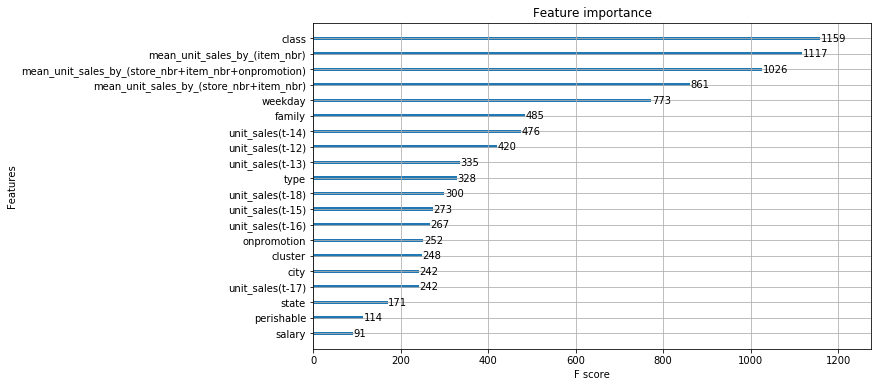

In [28]:
xgb.plot_importance(bsts[0])

In [30]:
param['task'] = 'prediction'
start = '2017-07-01'
end = '2017-08-15'
train = extract_by_date(df, start, end)
train_X = train[x_cols]
train_y = train['unit_sales']
train_weights = get_weights(train['item_nbr'])
train_dataset = xgb.DMatrix(train_X, label=train_y, weight=train_weights, feature_names=x_cols)
bst = xgb.train(param, train_dataset, num_round)

In [31]:
test = pd.read_csv('./data/test_processed.csv', dtype=types)
test, _ = extend_dataset(test, items, stores)
df_prev = extract_by_date(df, '2017-07-25', '2017-08-15')

test, _ = fill_lagged(test, df_prev, 12, 18)
test, _ = fill_mean_encoding(test, df_prev, combinations)
test.perishable = test.perishable.astype('bool')

test_X = test[x_cols]
test_dataset = xgb.DMatrix(data=test_X)
test['unit_sales'] = bst.predict(test_dataset)

/home/ubuntu/.local/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ubuntu/grocery/model.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_prev[colname] = df_prev['unit_sales']


In [32]:
test.sort_values(by='id', inplace=True)
test.ix[test.unit_sales < 0, 'unit_sales'] = 0
test['unit_sales'] = np.expm1(test['unit_sales'])
test[['id', 'unit_sales']].to_csv('./submissions/xgb_mean_encoded_lagged_0.542.csv.gz', float_format="%.4f", index=False, compression='gzip')
!telegram-send "Submission is done."

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
